In [2]:
#Import libraries
import pandas as pd
import numpy as np
import re
import string
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras import backend as K
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to C:\Users\Saiful
[nltk_data]     IN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Saiful
[nltk_data]     IN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Saiful
[nltk_data]     IN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Saiful
[nltk_data]     IN\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Saiful
[nltk_data]     IN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
# Load the dataset
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
# Display basic info 
print("Dataset Overview:")
print('train:\n', train_df.info())
print('test:\n', test_df.info())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB
train:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   test_id    1048575 non-null  int64 
 1   question1  1048574 non-null  object
 2   question2  1048572 non-null  object
dtypes: int64(1), object(2)
memory usage: 24.0+ MB
test:
 None


In [5]:
# Check first few rows - Train
print(train_df.head())

   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  


In [6]:
# Check first few rows - Test
print(test_df.head())

   test_id                                          question1  \
0        0  How does the Surface Pro himself 4 compare wit...   
1        1  Should I have a hair transplant at age 24? How...   
2        2  What but is the best way to send money from Ch...   
3        3                        Which food not emulsifiers?   
4        4                   How "aberystwyth" start reading?   

                                           question2  
0  Why did Microsoft choose core m3 and not core ...  
1        How much cost does hair transplant require?  
2                      What you send money to China?  
3                                  What foods fibre?  
4                     How their can I start reading?  


In [7]:
# Checking for missing values - train
print("\nMissing Values:")
print(train_df.isnull().sum())


Missing Values:
id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64


In [8]:
# Drop missing values
train_df = train_df.dropna()

In [9]:
# Checking for missing values - test
print(test_df.isnull().sum())

test_id      0
question1    1
question2    3
dtype: int64


In [10]:
# Drop missing values - test
train_df = train_df.dropna()

# Step 1: Exploratory Data Analysis (EDA)

### Visualize distribution of target variable - Train
Distribution of 'is_duplicate: 0-255024, 1-149263

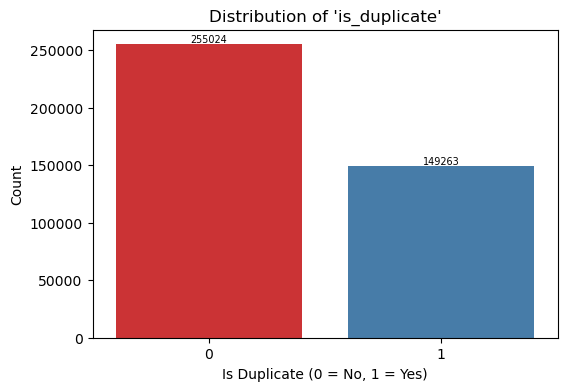

In [12]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=train_df, x='is_duplicate', hue='is_duplicate', palette='Set1', legend=False)

# Add count labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=7)

plt.title("Distribution of 'is_duplicate'")
plt.xlabel("Is Duplicate (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

In [13]:
# Percentage of duplicate vs non-duplicate
duplicate_ratio = train_df['is_duplicate'].value_counts(normalize=True) * 100
print("\nDuplicate Percentage:\n", duplicate_ratio)


Duplicate Percentage:
 is_duplicate
0    63.079941
1    36.920059
Name: proportion, dtype: float64


### Sentence length analysis
Higher number of length of both Q1 and Q2 by character count is between 0-200

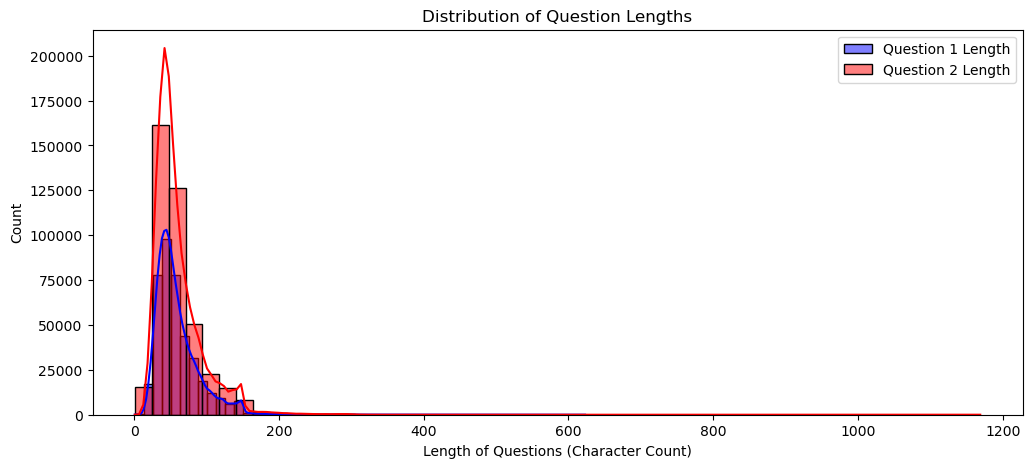

In [14]:
train_df['q1_length'] = train_df['question1'].astype(str).apply(len)
train_df['q2_length'] = train_df['question2'].astype(str).apply(len)

plt.figure(figsize=(12, 5))
sns.histplot(train_df['q1_length'], bins=50, kde=True, color='blue', label='Question 1 Length')
sns.histplot(train_df['q2_length'], bins=50, kde=True, color='red', label='Question 2 Length')
plt.legend()
plt.title("Distribution of Question Lengths")
plt.xlabel("Length of Questions (Character Count)")
plt.show()

### Word count analysis
Higher Number of Words in both Q1 and Q2 is between 0-50

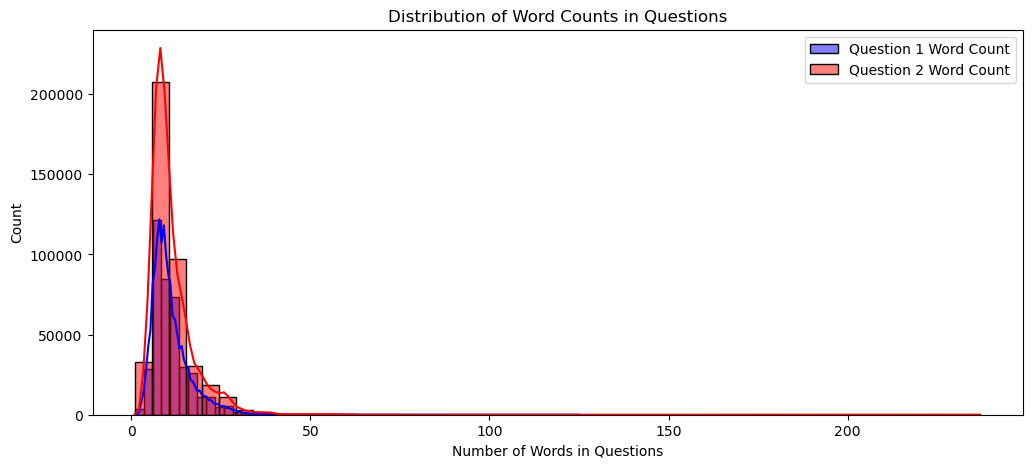

In [15]:
train_df['q1_word_count'] = train_df['question1'].astype(str).apply(lambda x: len(x.split()))
train_df['q2_word_count'] = train_df['question2'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))
sns.histplot(train_df['q1_word_count'], bins=50, kde=True, color='blue', label='Question 1 Word Count')
sns.histplot(train_df['q2_word_count'], bins=50, kde=True, color='red', label='Question 2 Word Count')
plt.legend()
plt.title("Distribution of Word Counts in Questions")
plt.xlabel("Number of Words in Questions")
plt.show()

### Word cloud of questions
A word cloud is a visual representation of text data, where the size and color of each word reflects its frequency and importance.

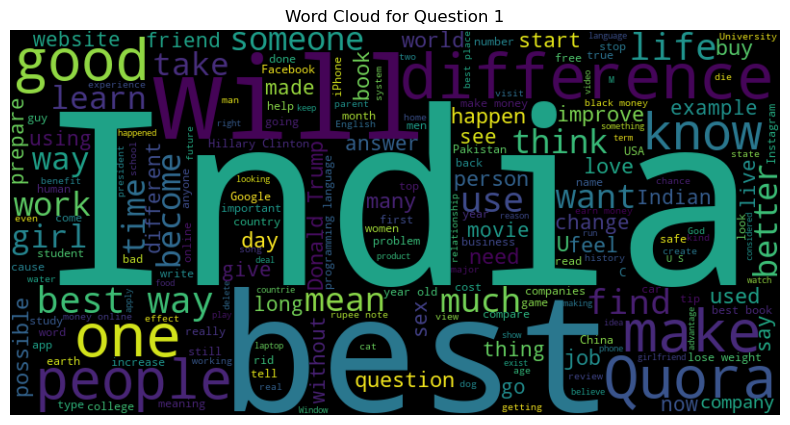

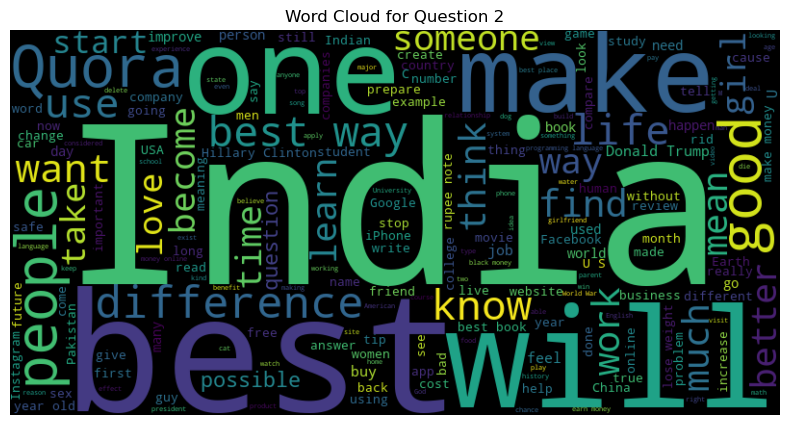

In [16]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, stopwords=STOPWORDS, background_color="black").generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

generate_wordcloud(train_df["question1"].astype(str), "Word Cloud for Question 1")
generate_wordcloud(train_df["question2"].astype(str), "Word Cloud for Question 2")

### Word cloud for duplicate and non-duplicate questions

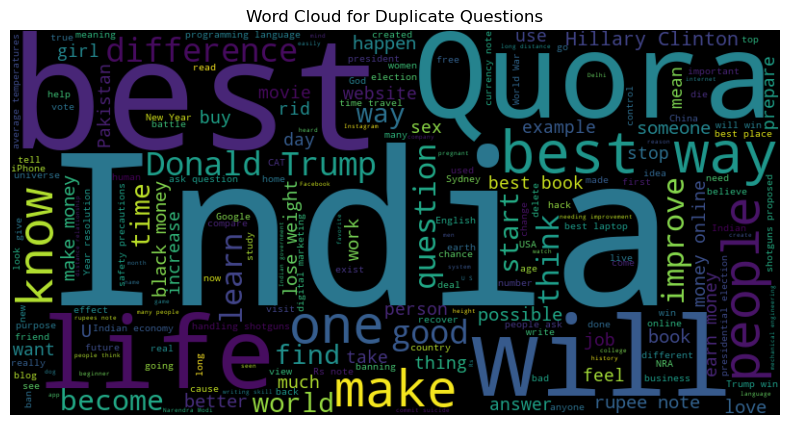

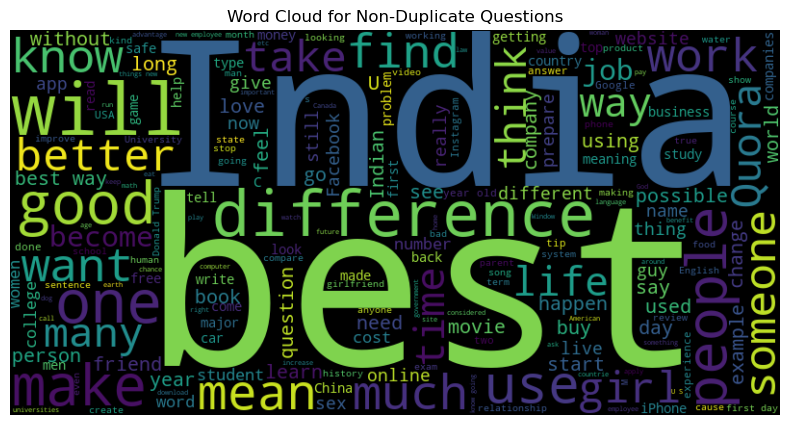

In [17]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

generate_wordcloud(train_df[train_df['is_duplicate'] == 1]['question1'].dropna(), "Word Cloud for Duplicate Questions")
generate_wordcloud(train_df[train_df['is_duplicate'] == 0]['question1'].dropna(), "Word Cloud for Non-Duplicate Questions")

In [18]:
# Common words in duplicate and non-duplicate questions
def get_most_common_words(text, top_n=20):
    words = " ".join(text.dropna()).lower().split()  
    words = [word for word in words if word.isalpha()]  # Remove punctuation/numbers
    return pd.Series(words).value_counts().head(top_n)

# Get most common words for Question 1 and Question 2
common_words_q1 = get_most_common_words(train_df["question1"])
common_words_q2 = get_most_common_words(train_df["question2"])

### Visualize the common words of Question 1 and Question 2
the, what, is how a, i , to, in... these are the top common words in both questions

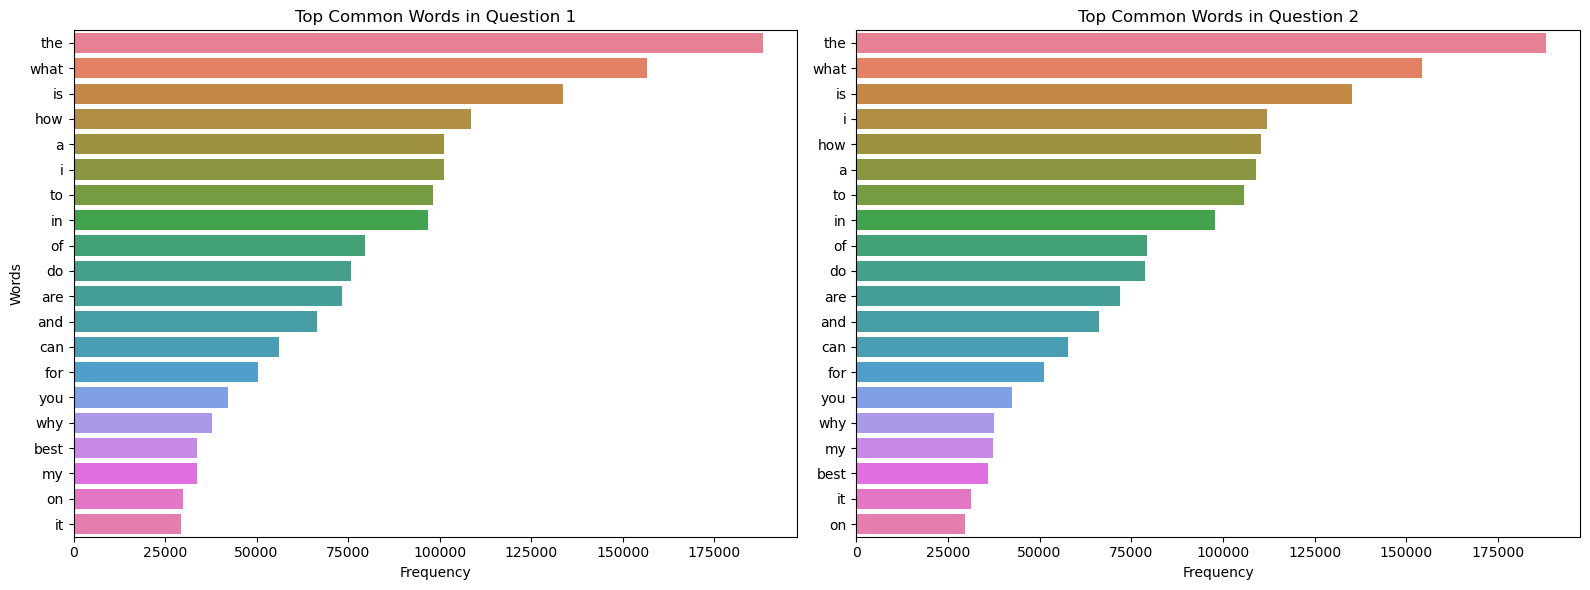

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Question 1
sns.barplot(x=common_words_q1.values, y=common_words_q1.index, ax=axes[0], hue=common_words_q1.index, legend=False)
axes[0].set_title("Top Common Words in Question 1")
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("Words")

# Plot for Question 2
sns.barplot(x=common_words_q2.values, y=common_words_q2.index, ax=axes[1], hue=common_words_q2.index, legend=False)
axes[1].set_title("Top Common Words in Question 2")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("")

# Adjust layout
plt.tight_layout()
plt.show()

### Correlation heatmap
A correlation heatmap is a matrix of values that represent the correlation between each pair of variables in the dataset. The values are typically represented as colors, where:

Positive correlation: Values close to 1 indicate a strong positive correlation, where the variables tend to increase or decrease together.
Negative correlation: Values close to -1 indicate a strong negative correlation, where the variables tend to move in opposite directions.
No correlation: Values close to 0 indicate no correlation between the variables.

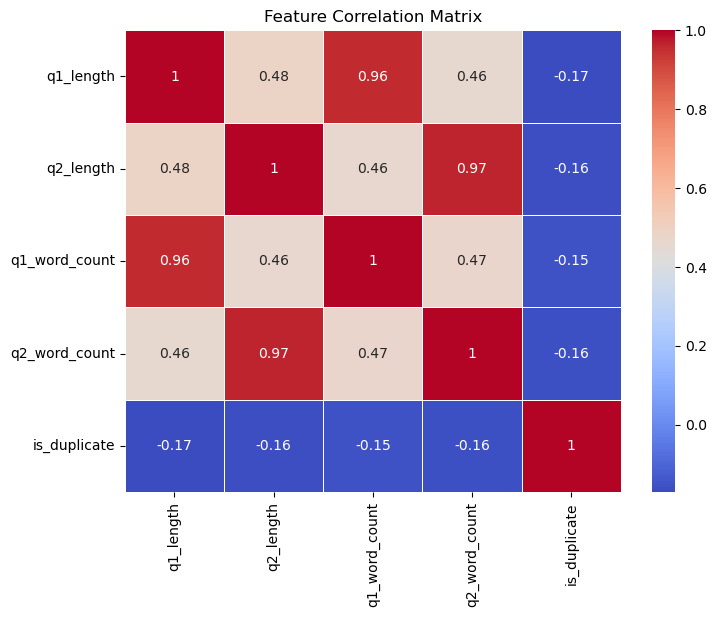

In [20]:
corr_matrix = train_df[['q1_length', 'q2_length', 'q1_word_count', 'q2_word_count', 'is_duplicate']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

### Jaccard Similarity Score
The Jaccard Similarity Score is a measure of similarity between two sets of data where score ranges from 0 (no similarity) to 1 (identical). Here we see mostly questions have no similarity.

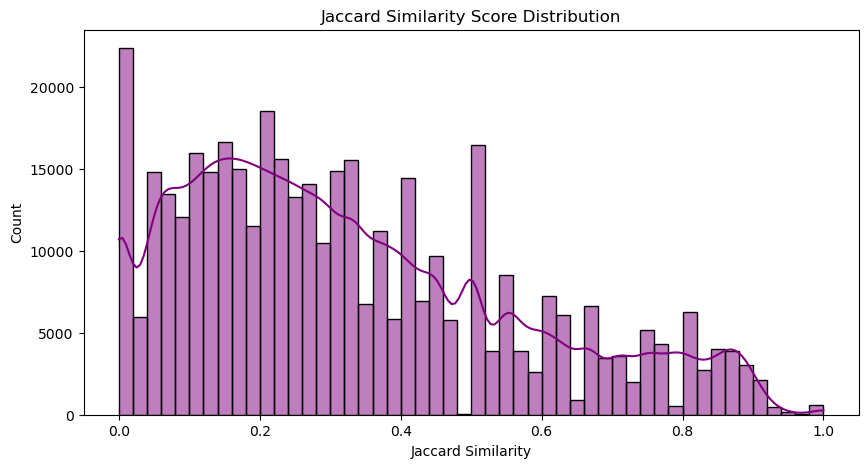

In [23]:
def jaccard_similarity(q1, q2):
    q1_words = set(q1.lower().split())
    q2_words = set(q2.lower().split())
    intersection = len(q1_words.intersection(q2_words))
    union = len(q1_words.union(q2_words))
    return intersection / union if union != 0 else 0

train_df['jaccard_sim'] = train_df.apply(lambda row: jaccard_similarity(str(row['question1']), str(row['question2'])), axis=1)

plt.figure(figsize=(10, 5))
sns.histplot(train_df['jaccard_sim'], bins=50, kde=True, color='purple')
plt.title("Jaccard Similarity Score Distribution")
plt.xlabel("Jaccard Similarity")
plt.show()

In [24]:
#Unique question count
unique_questions = set(train_df['question1']).union(set(train_df['question2']))
print(f"Total unique questions in dataset: {len(unique_questions)}")

Total unique questions in dataset: 537358


In [25]:
# Top frequently asked question pairs
question_pairs = train_df[['question1', 'question2']].apply(lambda x: tuple(sorted([x['question1'], x['question2']])), axis=1)
pair_counts = Counter(question_pairs)
top_duplicate_pairs = pair_counts.most_common(10)

print("\nTop 10 most frequent question pairs:")
for pair, count in top_duplicate_pairs:
    print(f"{pair} - {count} times")


Top 10 most frequent question pairs:
('What is the step by step guide to invest in share market in india?', 'What is the step by step guide to invest in share market?') - 1 times
('What is the story of Kohinoor (Koh-i-Noor) Diamond?', 'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?') - 1 times
('How can I increase the speed of my internet connection while using a VPN?', 'How can Internet speed be increased by hacking through DNS?') - 1 times
('Find the remainder when [math]23^{24}[/math] is divided by 24,23?', 'Why am I mentally very lonely? How can I solve it?') - 1 times
('Which fish would survive in salt water?', 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?') - 1 times
('Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?', "I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?") - 1 times
('Should I buy tiago?', 'What keeps childern act

# Step 2: Text Preprocessing

In [27]:
# Initialize Stopwords
stop_words = set(stopwords.words('english'))

# Initialize Lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

In [28]:
# Function for cleaning and preprocessing text
def preprocess_text(text):
    
    text = text.lower()  # Convert to lowercase
    text = text.replace("’", "'")
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    
    words = word_tokenize(text)  # Tokenization
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return " ".join(words)

In [29]:
# Apply text preprocessing to the train dataset
train_df['cleaned_question1'] = train_df['question1'].astype(str).swifter.apply(preprocess_text)
train_df['cleaned_question2'] = train_df['question2'].astype(str).swifter.apply(preprocess_text)

# Apply text preprocessing to the test dataset
test_df['cleaned_question1'] = test_df['question1'].astype(str).swifter.apply(preprocess_text)
test_df['cleaned_question2'] = test_df['question2'].astype(str).swifter.apply(preprocess_text)

Pandas Apply:   0%|          | 0/404287 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/404287 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1048575 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1048575 [00:00<?, ?it/s]

In [30]:
# Check sample results
print(train_df[['question1', 'cleaned_question1']].head())
print(test_df[['question1', 'cleaned_question1']].head())

                                           question1  \
0  What is the step by step guide to invest in sh...   
1  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2  How can I increase the speed of my internet co...   
3  Why am I mentally very lonely? How can I solve...   
4  Which one dissolve in water quikly sugar, salt...   

                                   cleaned_question1  
0          step step guide invest share market india  
1                    story kohinoor kohinoor diamond  
2       increase speed internet connection using vpn  
3                              mentally lonely solve  
4  one dissolve water quikly sugar salt methane c...  
                                           question1  \
0  How does the Surface Pro himself 4 compare wit...   
1  Should I have a hair transplant at age 24? How...   
2  What but is the best way to send money from Ch...   
3                        Which food not emulsifiers?   
4                   How "aberystwyth" start reading? 

In [31]:
# Drop original columns 
train_df.drop(columns=['question1', 'question2'], inplace=True)
test_df.drop(columns=['question1', 'question2'], inplace=True)

## Feature Extraction

### TF-IDF for Logistic Regression

In [33]:
tfidf_vectorizer = TfidfVectorizer(max_features=6000)

# Fit & transform on cleaned text
tfidf_train_q1 = tfidf_vectorizer.fit_transform(train_df["cleaned_question1"])
tfidf_train_q2 = tfidf_vectorizer.transform(train_df["cleaned_question2"])

tfidf_test_q1 = tfidf_vectorizer.transform(test_df["cleaned_question1"])
tfidf_test_q2 = tfidf_vectorizer.transform(test_df["cleaned_question2"])

# Combine features using sparse matrices (efficient)
tfidf_train = hstack([tfidf_train_q1, tfidf_train_q2])  
tfidf_test = hstack([tfidf_test_q1, tfidf_test_q2])  

In [34]:
# Check Shapes for TF-IDF Feature Extraction
print("TF-IDF Feature Shapes:")
print("Train Q1 TF-IDF:", tfidf_train_q1.shape)
print("Train Q2 TF-IDF:", tfidf_train_q2.shape)
print("Test Q1 TF-IDF:", tfidf_test_q1.shape)
print("Test Q2 TF-IDF:", tfidf_test_q2.shape)

# Ensure consistency in feature dimensions
assert tfidf_train_q1.shape == tfidf_train_q2.shape, "Mismatch in Train Q1 & Q2 TF-IDF shape!"
assert tfidf_test_q1.shape == tfidf_test_q2.shape, "Mismatch in Test Q1 & Q2 TF-IDF shape!"

# Check combined TF-IDF features
print("\nCombined TF-IDF Shapes:")
print("Train TF-IDF:", tfidf_train.shape)
print("Test TF-IDF:", tfidf_test.shape)

# Ensure correct concatenation
assert tfidf_train.shape[0] == train_df.shape[0], "Mismatch in TF-IDF Train Samples!"
assert tfidf_test.shape[0] == test_df.shape[0], "Mismatch in TF-IDF Test Samples!"

TF-IDF Feature Shapes:
Train Q1 TF-IDF: (404287, 6000)
Train Q2 TF-IDF: (404287, 6000)
Test Q1 TF-IDF: (1048575, 6000)
Test Q2 TF-IDF: (1048575, 6000)

Combined TF-IDF Shapes:
Train TF-IDF: (404287, 12000)
Test TF-IDF: (1048575, 12000)


### Tokenization & Padding for Deep Learning Models

In [35]:
max_words = 20000  # Limit vocabulary size for faster training
max_len = 64  # Max sequence length

# Tokenizer using preprocessed text
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["cleaned_question1"].values.tolist() + train_df["cleaned_question2"].values.tolist())

# Convert cleaned text to sequences
train_sequences_q1 = tokenizer.texts_to_sequences(train_df["cleaned_question1"].values)
train_sequences_q2 = tokenizer.texts_to_sequences(train_df["cleaned_question2"].values)
test_sequences_q1 = tokenizer.texts_to_sequences(test_df["cleaned_question1"].values)
test_sequences_q2 = tokenizer.texts_to_sequences(test_df["cleaned_question2"].values)

# Padding sequences (Convert to NumPy arrays for efficiency)
train_q1_padded = np.array(pad_sequences(train_sequences_q1, maxlen=max_len, padding='post'))
train_q2_padded = np.array(pad_sequences(train_sequences_q2, maxlen=max_len, padding='post'))
test_q1_padded = np.array(pad_sequences(test_sequences_q1, maxlen=max_len, padding='post'))
test_q2_padded = np.array(pad_sequences(test_sequences_q2, maxlen=max_len, padding='post'))

In [36]:
# Check Shapes for LSTM/GRU/ANN Models
print("Tokenized & Padded Shapes:")
print("Train Q1:", train_q1_padded.shape)
print("Train Q2:", train_q2_padded.shape)
print("Test Q1:", test_q1_padded.shape)
print("Test Q2:", test_q2_padded.shape)

# Ensure the number of samples match in both question columns
assert train_q1_padded.shape == train_q2_padded.shape, "Mismatch in train Q1 & Q2 shape!"
assert test_q1_padded.shape == test_q2_padded.shape, "Mismatch in test Q1 & Q2 shape!"

Tokenized & Padded Shapes:
Train Q1: (404287, 64)
Train Q2: (404287, 64)
Test Q1: (1048575, 64)
Test Q2: (1048575, 64)


### Train-Validation Split
80% train, 20% validation.
Each model trains on the train set and evaluates on the validation set.
Validation accuracy is printed for comparison.
Test dataset is not used yet (we’ll use the best model later).

In [42]:
# Train-Validation Split
X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(tfidf_train, train_df["is_duplicate"], test_size=0.2, random_state=42)
X_train_seq_q1, X_val_seq_q1, X_train_seq_q2, X_val_seq_q2, y_train_seq, y_val_seq = train_test_split(
    train_q1_padded, train_q2_padded, train_df["is_duplicate"], test_size=0.2, random_state=42
)

# Step 3: Model Creation

## Artificial Neural Network (ANN)

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Define ANN Model
ann_model = Sequential([
    Input(shape=(X_train_tfidf.shape[1],)), 
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

# Define Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    """
    Reduces learning rate by 10% every 3 epochs after the 5th epoch.
    """
    if epoch < 5:
        return lr  
    else:
        return float(lr * tf.math.exp(-0.1).numpy())  # Reduce learning rate by 10%

# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True 
)

# Compile Model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history = ann_model.fit(X_train_tfidf, y_train,
              validation_data=(X_val_tfidf, y_val),
              batch_size=2048, epochs=15, verbose=1,
              callbacks=[LearningRateScheduler(lr_scheduler), early_stopping])

# Save the model
ann_model.save("ann_model.h5")

# Evaluate Model
ann_acc = ann_model.evaluate(X_val_tfidf, y_val, verbose=0)[1]
print(f"ANN Accuracy: {ann_acc:.4f}")

Epoch 1/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 105s 622ms/step - accuracy: 0.6959 - loss: 0.6213 - val_accuracy: 0.6311 - val_loss: 0.7973 - learning_rate: 0.0010
Epoch 2/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 92s 583ms/step - accuracy: 0.8007 - loss: 0.4246 - val_accuracy: 0.6317 - val_loss: 1.4161 - learning_rate: 0.0010
Epoch 3/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 93s 590ms/step - accuracy: 0.8531 - loss: 0.3265 - val_accuracy: 0.6388 - val_loss: 1.5754 - learning_rate: 0.0010
Epoch 4/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 93s 585ms/step - accuracy: 0.8867 - loss: 0.2612 - val_accuracy: 0.7350 - val_loss: 0.8810 - learning_rate: 0.0010
Epoch 5/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 94s 591ms/step - accuracy: 0.9070 - loss: 0.2191 - val_accuracy: 0.8023 - val_loss: 0.6301 - learning_rate: 0.0010
Epoch 6/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 92s 580ms/step - accuracy: 0.9211 - loss: 0.1880 - val_accuracy: 0.8117 - val_loss: 0.6061 - learning_rate: 9.0484e-04
Epoch 7/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 91s 574ms/step - accuracy

# Step 4: Model Evaluation

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on validation set
y_pred_prob = ann_model.predict(X_val_tfidf)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print("ANN:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

2527/2527 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step
ANN:
Accuracy: 0.8117
Precision: 0.8005
Recall: 0.6521
F1-score: 0.7187


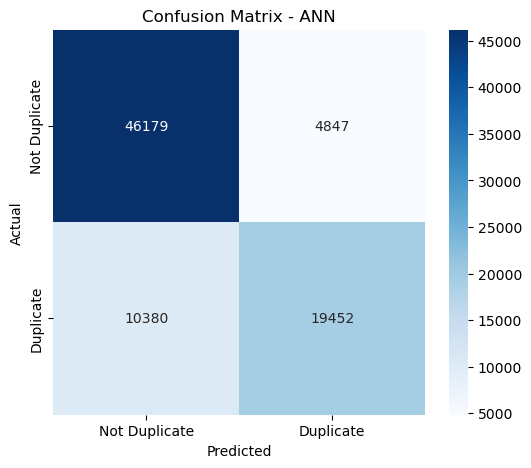

In [50]:
# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Duplicate", "Duplicate"], yticklabels=["Not Duplicate", "Duplicate"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ANN")
plt.show()

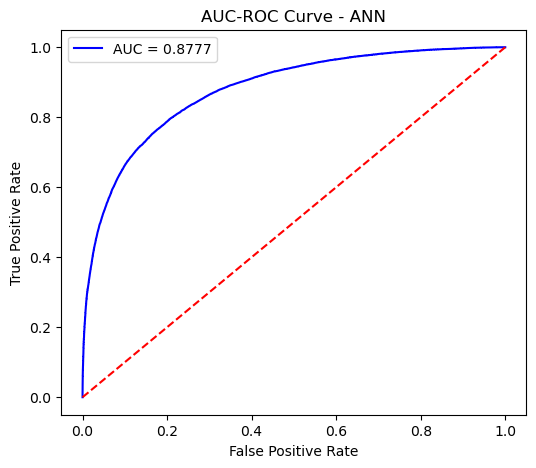

In [51]:
# AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve - ANN")
plt.legend()
plt.show()

# Step 5: Model Tuning and Hyperparameter Optimization
For model tuning i use Keras Tuner (Faster than RandomizedSearchCV) which optimizes without re-training bad models and enable parallel tuning – Unlike RandomizedSearchCV, which trains models sequentially.

In [87]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.optimizers import Adam, SGD

# Function to create ANN model with tunable hyperparameters
def build_ann_model(hp):
    neurons = hp.Choice('neurons', [512, 256])
    activation = hp.Choice('activation', ['relu', 'sigmoid'])
    optimizer_name = hp.Choice('optimizer', ['adam', 'sgd'])
    learning_rate = hp.Choice('learning_rate', [0.001, 0.01])
    dropout_rate = hp.Choice('dropout_rate', [0.3, 0.4])

    model = Sequential([
        Input(shape=(X_train_tfidf.shape[1],)), 
        
        Dense(neurons),
        BatchNormalization(),
        Activation(activation),
        Dropout(dropout_rate),

        Dense(neurons // 2),
        BatchNormalization(),
        Activation(activation),
        Dropout(dropout_rate),

        Dense(128),
        BatchNormalization(),
        Activation(activation),
        Dropout(0.2),

        Dense(1, activation='sigmoid')
    ])

    # Define optimizer with tunable learning rate
    optimizers = {
        'adam': Adam(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate, momentum=0.9)
    }
    optimizer = optimizers[optimizer_name]

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize Keras Tuner RandomSearch
tuner = kt.RandomSearch(
    build_ann_model,
    objective='val_accuracy',
    max_trials=5,  
    executions_per_trial=1,  
    directory='tuner_dir',
    project_name='ann_hyperparam_tuning'
)

# Search for the best hyperparameters
tuner.search(X_train_tfidf, y_train, 
             validation_data=(X_val_tfidf, y_val),
             epochs=10,  
             batch_size=1024,  
             verbose=1)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train best model
best_ann_model = tuner.hypermodel.build(best_hps)

best_ann_model.fit(X_train_tfidf, y_train, 
                   validation_data=(X_val_tfidf, y_val),
                   batch_size=1024,  
                   epochs=10,  
                   verbose=1)

# Save the model
best_ann_model.save("best_ann_model.h5")

Reloading Tuner from tuner_dir\ann_hyperparam_tuning\tuner0.json
Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 78s 220ms/step - accuracy: 0.6857 - loss: 0.6010 - val_accuracy: 0.6323 - val_loss: 0.9035
Epoch 2/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 63s 198ms/step - accuracy: 0.7847 - loss: 0.4521 - val_accuracy: 0.7437 - val_loss: 0.5644
Epoch 3/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 62s 197ms/step - accuracy: 0.8160 - loss: 0.3912 - val_accuracy: 0.7938 - val_loss: 0.4536
Epoch 4/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 63s 200ms/step - accuracy: 0.8434 - loss: 0.3401 - val_accuracy: 0.7971 - val_loss: 0.4635
Epoch 5/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 63s 199ms/step - accuracy: 0.8646 - loss: 0.3009 - val_accuracy: 0.8024 - val_loss: 0.4701
Epoch 6/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 70s 220ms/step - accuracy: 0.8804 - loss: 0.2680 - val_accuracy: 0.8026 - val_loss: 0.4802
Epoch 7/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 62s 195ms/step - accuracy: 0.8949 - loss: 0.2409 - val_accuracy: 0.8066 - val_loss: 0.4987
Epoch 8/10
316/316

ANN Accuracy: 0.8087
Best Hyperparameters: {'neurons': 256, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'dropout_rate': 0.3}


In [114]:
# Evaluate the Model
best_ann_acc = best_ann_model.evaluate(X_val_tfidf, y_val, verbose=0)[1]
print(f"Best ANN Accuracy: {best_ann_acc:.4f}")
print("Best Hyperparameters:", best_hps.values)

Best ANN Accuracy: 0.8087
Best Hyperparameters: {'neurons': 256, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'dropout_rate': 0.3}


## Baseline Model (Logistic Regression)

In [89]:
# Import required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib  # For saving the model

# Train Logistic Regression Model
logreg = LogisticRegression(max_iter=500, solver='lbfgs', n_jobs=-1)
logreg.fit(X_train_tfidf, y_train)

# Predict & Evaluate
y_pred_logreg = logreg.predict(X_val_tfidf)
logreg_acc = accuracy_score(y_val, y_pred_logreg)

print(f"Logistic Regression Accuracy: {logreg_acc:.4f}")

# Save the trained model using joblib
joblib.dump(logreg, 'logistic_regression_model.pkl')  # Save as a pickle file

print("Logistic Regression model saved as logistic_regression_model.pkl")


# load the model
# loaded_logreg = joblib.load('logistic_regression_model.pkl')
# y_pred_loaded = loaded_logreg.predict(X_test_tfidf) 

Logistic Regression Accuracy: 0.7380
Logistic Regression model saved as logistic_regression_model.pkl


In [90]:
# Predict probabilities on validation set
y_val_probs_logreg = logreg.predict_proba(X_val_tfidf)[:, 1]  
y_val_pred_logreg = (y_val_probs_logreg > 0.5).astype(int)  

# Calculate Metrics
accuracy_logreg = accuracy_score(y_val, y_val_pred_logreg)
precision_logreg = precision_score(y_val, y_val_pred_logreg)
recall_logreg = recall_score(y_val, y_val_pred_logreg)
f1_logreg = f1_score(y_val, y_val_pred_logreg)

# Print Performance Metrics
print("Logistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy_logreg:.4f}")
print(f"Precision: {precision_logreg:.4f}")
print(f"Recall: {recall_logreg:.4f}")
print(f"F1 Score: {f1_logreg:.4f}")

Logistic Regression Model Evaluation:
Accuracy: 0.7380
Precision: 0.6942
Recall: 0.5183
F1 Score: 0.5935


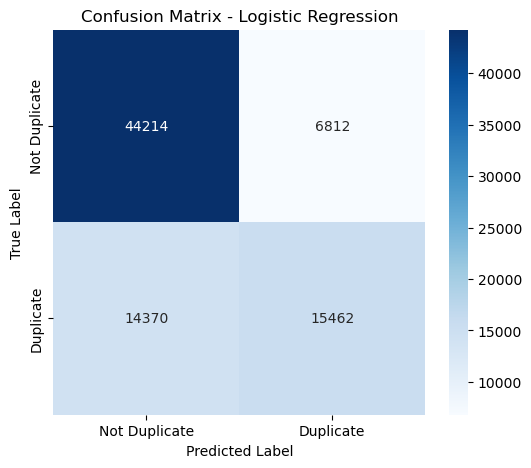

In [91]:
# Confusion Matrix
conf_matrix_logreg = confusion_matrix(y_val, y_val_pred_logreg)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Duplicate', 'Duplicate'], yticklabels=['Not Duplicate', 'Duplicate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

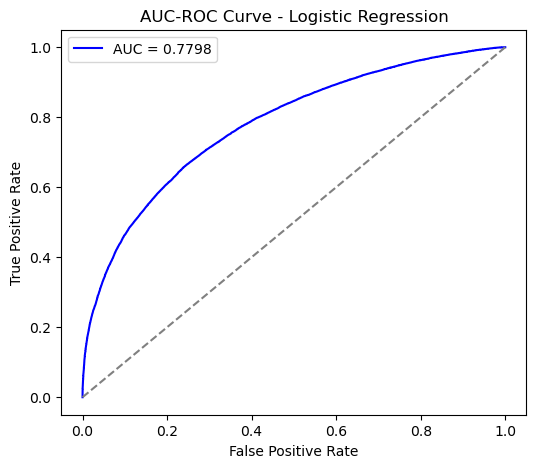

In [92]:
# AUC-ROC Curve
fpr_logreg, tpr_logreg, _ = roc_curve(y_val, y_val_probs_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

plt.figure(figsize=(6, 5))
plt.plot(fpr_logreg, tpr_logreg, color='blue', label=f'AUC = {roc_auc_logreg:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve - Logistic Regression')
plt.legend()
plt.show()

## LSTM/GRU Model (Sequence-based Learning)

In [94]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Concatenate, BatchNormalization

# Define Input Layers
input_q1 = Input(shape=(X_train_seq_q1.shape[1],))
input_q2 = Input(shape=(X_train_seq_q2.shape[1],))

# Shared Embedding Layer
embedding_layer = Embedding(input_dim=max_words, output_dim=128)

# Optimized LSTM Block
def lstm_block(input_layer):
    x = embedding_layer(input_layer)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)  # BiLSTM for better accuracy
    x = BatchNormalization()(x)  
    x = Dropout(0.3)(x) 
    return x

# Process Q1 & Q2
x1 = lstm_block(input_q1)
x2 = lstm_block(input_q2)

# Merge Outputs
merged = Concatenate()([x1, x2])
merged = Dense(128, activation='relu')(merged)  # Larger dense layer for better feature extraction
merged = Dropout(0.3)(merged)
merged = Dense(64, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(merged)

# Define Model
lstm_model = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile Model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history = lstm_model.fit([X_train_seq_q1, X_train_seq_q2], y_train,
                    validation_data=([X_val_seq_q1, X_val_seq_q2], y_val),
                    batch_size=2048, epochs=5, verbose=1)

# Evaluate Model
lstm_acc = lstm_model.evaluate([X_val_seq_q1, X_val_seq_q2], y_val, verbose=0)[1]
print(f"LSTM Accuracy: {lstm_acc:.4f}")

# Save the model in the new Keras format
lstm_model.save("lstm_model.keras")
print("LSTM model saved as lstm_model.keras")

# load the model 
# loaded_lstm_model = tf.keras.models.load_model("lstm_model.keras")
# predictions = loaded_lstm_model.predict([X_test_seq_q1, X_test_seq_q2])

Epoch 1/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 572s 4s/step - accuracy: 0.7028 - loss: 0.5555 - val_accuracy: 0.6312 - val_loss: 0.6476
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 551s 3s/step - accuracy: 0.7873 - loss: 0.4434 - val_accuracy: 0.7061 - val_loss: 0.6437
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 552s 3s/step - accuracy: 0.8146 - loss: 0.3903 - val_accuracy: 0.6908 - val_loss: 0.5605
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 553s 4s/step - accuracy: 0.8385 - loss: 0.3468 - val_accuracy: 0.6649 - val_loss: 0.6760
Epoch 5/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 554s 4s/step - accuracy: 0.8555 - loss: 0.3157 - val_accuracy: 0.7620 - val_loss: 0.5066
LSTM Accuracy: 0.7620
LSTM model saved as lstm_model.keras


In [95]:
# Predict probabilities & binary labels
y_val_probs_lstm = lstm_model.predict([X_val_seq_q1, X_val_seq_q2])  # Get probability scores
y_val_pred_lstm = (y_val_probs_lstm > 0.5).astype(int)  # Convert to binary labels

# Calculate Metrics
accuracy_lstm = accuracy_score(y_val, y_val_pred_lstm)
precision_lstm = precision_score(y_val, y_val_pred_lstm)
recall_lstm = recall_score(y_val, y_val_pred_lstm)
f1_lstm = f1_score(y_val, y_val_pred_lstm)

# Print Performance Metrics
print("LSTM Model Evaluation:")
print(f"Accuracy: {accuracy_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}")
print(f"Recall: {recall_lstm:.4f}")
print(f"F1 Score: {f1_lstm:.4f}")

2527/2527 ━━━━━━━━━━━━━━━━━━━━ 346s 136ms/step
LSTM Model Evaluation:
Accuracy: 0.7620
Precision: 0.7200
Recall: 0.5810
F1 Score: 0.6430


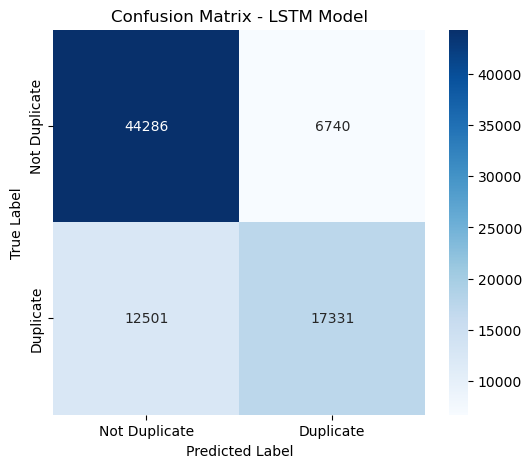

In [96]:
# Confusion Matrix
conf_matrix_lstm = confusion_matrix(y_val, y_val_pred_lstm)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Duplicate', 'Duplicate'], yticklabels=['Not Duplicate', 'Duplicate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LSTM Model')
plt.show()

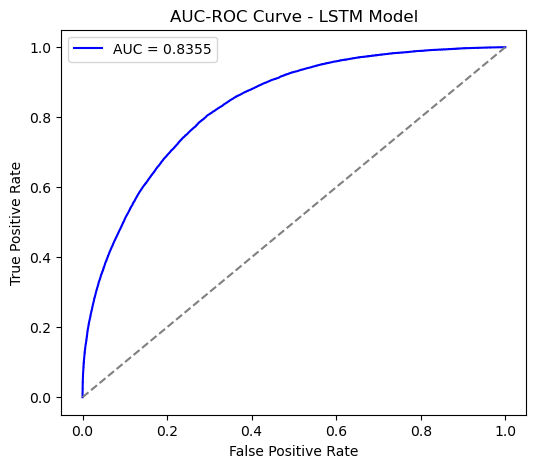

In [97]:
# AUC-ROC Curve
fpr_lstm, tpr_lstm, _ = roc_curve(y_val, y_val_probs_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(6, 5))
plt.plot(fpr_lstm, tpr_lstm, color='blue', label=f'AUC = {roc_auc_lstm:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve - LSTM Model')
plt.legend()
plt.show()

### Model Comparison Table

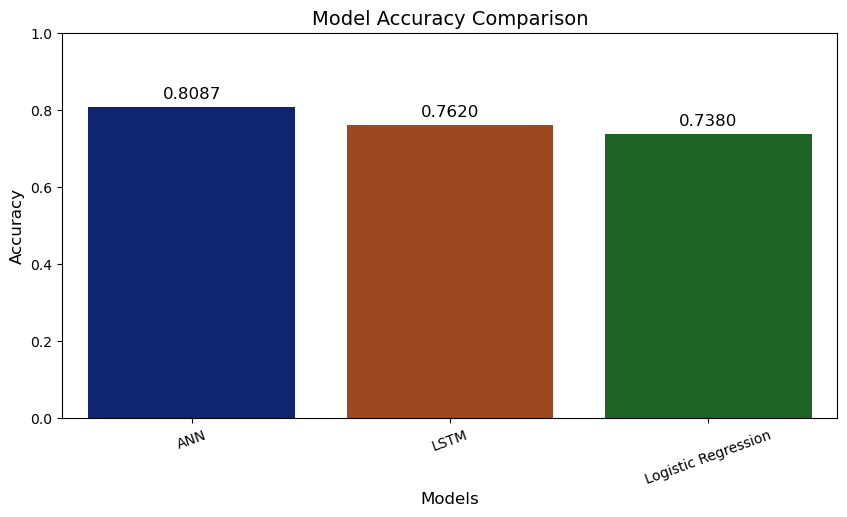

In [120]:
# Store Model Accuracies
model_accuracies = {
    "Logistic Regression": logreg_acc,
    "ANN": ann_acc,
    "LSTM": lstm_acc,
}

# Sort Models by Accuracy for Better Visualization
sorted_models = dict(sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True))

# Plot Accuracy Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=list(sorted_models.keys()), y=list(sorted_models.values()), palette="dark")
plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.xticks(rotation=20)

# Show Accuracy Values on Bars
for i, acc in enumerate(sorted_models.values()):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)

plt.show()

### Prediction & Submission

In [122]:
# Ensure TF-IDF features for test set are ready
print("Test TF-IDF Shape:", tfidf_test.shape)

# Make predictions using the trained ANN model
ann_test_predictions = ann_model.predict(tfidf_test, batch_size=512)

# Convert probabilities to binary labels (Threshold: 0.5)
ann_test_labels = (ann_test_predictions.flatten() >= 0.5).astype(int)

# Create Submission DataFrame
submission_df = pd.DataFrame({
    "test_id": test_df["test_id"],  
    "is_duplicate": ann_test_labels  # Binary predictions (0 or 1)
})

# Save Submission File
submission_filename = "ann_submission.csv"
submission_df.to_csv(submission_filename, index=False)

print(f"Submission file '{submission_filename}' saved successfully.")

Test TF-IDF Shape: (1048575, 12000)
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 211s 103ms/step
Submission file 'ann_submission.csv' saved successfully.


In [124]:
submission_df.head(10)

,test_id,is_duplicate
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0
5,5,0
6,6,1
7,7,1
8,8,0
9,9,0


In [126]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 2 columns):
 #   Column        Non-Null Count    Dtype
---  ------        --------------    -----
 0   test_id       1048575 non-null  int64
 1   is_duplicate  1048575 non-null  int32
dtypes: int32(1), int64(1)
memory usage: 12.0 MB
